<h1>CNN model for Alzheimer Detection and Classsification</h1>

## Imports

Importing basic Libraries/modules. If not installed, you can see to how to install [here](https://github.com/metarex21/Alzheimer-Prediction/tree/main#requirements) in the requirements section.

In [2]:
# Importing TensorFlow and Keras modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    BatchNormalization, Concatenate, Conv2D, Dense, Dropout, Flatten,
    GaussianNoise, GlobalAveragePooling2D, Input, MaxPooling2D, Rescaling,
    Resizing, SeparableConv2D)
import tensorflow.keras.layers as layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Importing data processing and visualization modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Importing scikit-learn modules
from sklearn.metrics import confusion_matrix

# Importing miscellaneous modules
import random
import time

## GPU

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
len(gpus)

0

In [6]:
import tensorflow as tf
print(tf.__version__)


2.12.0


## Training constansts

In [7]:
batch_size = 32
img_height = 220
img_width = 220
seed = 42

## Load data

Data is being Split here into 80:20 ratio where 80% is being used for training; rest for validation. You can find the dataset [here](https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset).

### 1.Training Dataset

In [8]:
train_data = tf.keras.utils.image_dataset_from_directory(
    "D:/GitHub/Alzheimer-Prediction/dataset",
    subset='training',
    validation_split=0.2,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 6400 files belonging to 4 classes.
Using 5120 files for training.


### 2.Validation Dataset

In [9]:
val_data = tf.keras.utils.image_dataset_from_directory(
    "D:/GitHub/Alzheimer-Prediction/dataset",
    subset='validation',
    validation_split=0.2,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


## Classes Names

Returns the number of classes and the corresponding class names in the train_data dataset by printing in output

In [10]:
class_names = train_data.class_names
num_classes = len(class_names)

print(f'{num_classes} classes: {class_names}')

4 classes: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


## Preparing dataset for training and evaluation

In [11]:
AUTOTUNE = tf.data.AUTOTUNEAUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

## Plotting example images

In [12]:
def plot_images(n_rows=3, n_cols=7, data=train_data):
    plt.figure(figsize=(n_cols*2, int(n_rows*1.8)))
    for images, labels in data.take(int((n_rows * n_cols) / batch_size) + 1): # "take" takes random batch 
        for i in range(n_rows*n_cols):
            ax = plt.subplot(n_rows, n_cols, i + 1)
            plt.imshow(images[i].numpy().astype("uint16"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

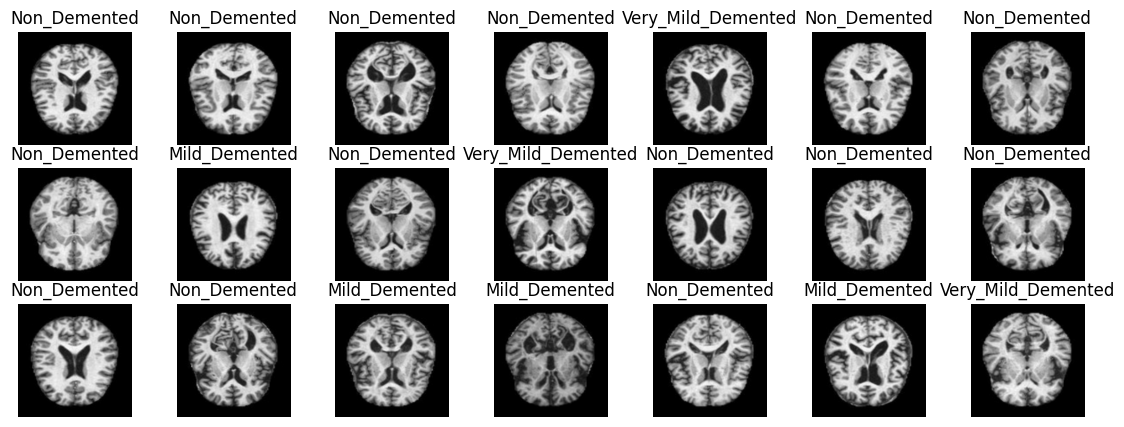

In [13]:
plot_images()

## Getting image and label batch shape

In [14]:
for image_batch, labels_batch in train_data:
    image_shape = image_batch.shape
    print(f"Image batch shape: {image_shape}")
    print(f"Label batch shape: {labels_batch.shape}")
    break

Image batch shape: (32, 220, 220, 3)
Label batch shape: (32,)


## Model

### 1. Creating normalization layer

In [15]:
normalization_layer = tf.keras.layers.Rescaling(scale=1./255)

### Branch

In [16]:
input_layer = Input(shape=(img_width, img_height, 3))
gaussian_noise = GaussianNoise(0.15)(input_layer)

In [17]:
branch_1 = normalization_layer(gaussian_noise)

branch_1 = Conv2D(32, (3,3), padding='same', activation="relu")(branch_1)
branch_1 = BatchNormalization()(branch_1)
branch_1 = MaxPooling2D((2, 2))(branch_1)

branch_1 = Conv2D(64, (3,3), padding='same', activation="relu")(branch_1)
branch_1 = BatchNormalization()(branch_1)
branch_1 = MaxPooling2D((2, 2))(branch_1)

branch_1 = Conv2D(128, (3,3), padding='same', activation="relu")(branch_1)
branch_1 = BatchNormalization()(branch_1)
branch_1 = MaxPooling2D((2, 2))(branch_1)

branch_1 = Conv2D(64, (3,3), padding='same', activation="relu")(branch_1)
branch_1 = BatchNormalization()(branch_1)
branch_1 = MaxPooling2D((2, 2))(branch_1)

branch_1 = Flatten()(branch_1)

In [18]:
output_layers = Dense(256, activation='relu')(branch_1)
output_layers = Dense(128, activation='relu')(output_layers)

output_layers = Dropout(0.5)(output_layers)

output_layers = Dense(num_classes, activation='softmax')(output_layers)

### Creating model instance

In [19]:
model = tf.keras.Model(input_layer, output_layers)

### Compiling an optimizer

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Model description

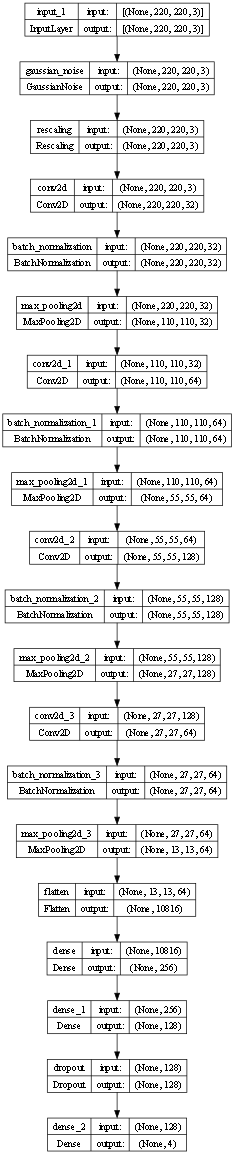

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=100)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 220, 220, 3)]     0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 220, 220, 3)      0         
 se)                                                             
                                                                 
 rescaling (Rescaling)       (None, 220, 220, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0     

## Callbacks

### 1. Early stopping

In [23]:
early_stopping= EarlyStopping(monitor='val_loss', patience=4,start_from_epoch=3,restore_best_weights=True)

### 2. ReduceLROnPlateau

In [24]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)

## Training

In [25]:
epochs = 40

history = model.fit(
  train_data,
  epochs = epochs,
  validation_data = val_data,
  batch_size = batch_size,
  callbacks = [early_stopping, reduce_lr],
  verbose = 1
)

Epoch 1/40
160/160 [==============================] - 360s 2s/step - loss: 1.1113 - accuracy: 0.5176 - val_loss: 1.7096 - val_accuracy: 0.5023 - lr: 1.0000e-04
Epoch 2/40
160/160 [==============================] - 344s 2s/step - loss: 0.8510 - accuracy: 0.6090 - val_loss: 1.6227 - val_accuracy: 0.5023 - lr: 1.0000e-04
Epoch 3/40
160/160 [==============================] - 331s 2s/step - loss: 0.7008 - accuracy: 0.6875 - val_loss: 1.1710 - val_accuracy: 0.5344 - lr: 1.0000e-04
Epoch 4/40
160/160 [==============================] - 329s 2s/step - loss: 0.5122 - accuracy: 0.7943 - val_loss: 0.5365 - val_accuracy: 0.7766 - lr: 1.0000e-04
Epoch 5/40
160/160 [==============================] - 319s 2s/step - loss: 0.3440 - accuracy: 0.8754 - val_loss: 0.3681 - val_accuracy: 0.8461 - lr: 1.0000e-04
Epoch 6/40
160/160 [==============================] - 320s 2s/step - loss: 0.2036 - accuracy: 0.9275 - val_loss: 0.2278 - val_accuracy: 0.9328 - lr: 1.0000e-04
Epoch 7/40
160/160 [====================

## Model training and validation metrics

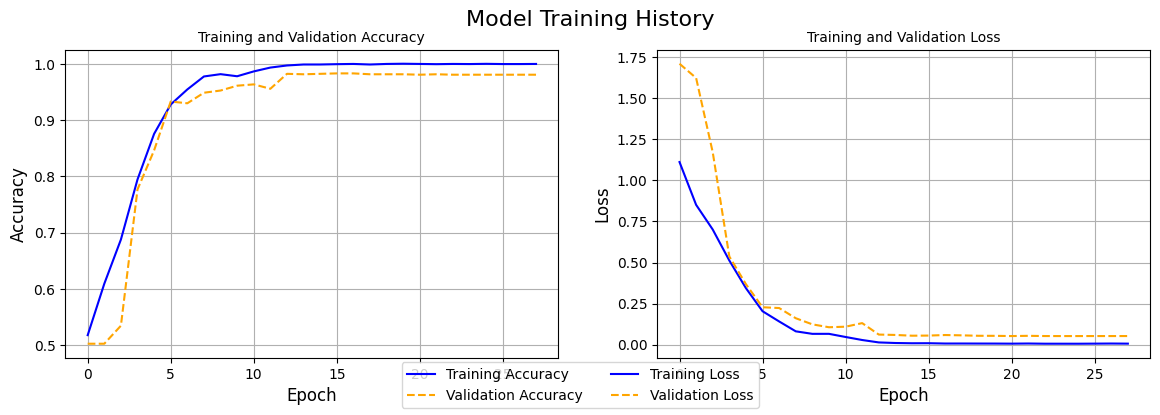

In [26]:
# Extract metrics from history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Plot accuracy metrics
ax1.plot(acc, label='Training Accuracy', color='blue', linestyle='solid')
ax1.plot(val_acc, label='Validation Accuracy', color='orange', linestyle='dashed')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Training and Validation Accuracy', fontsize=10)
ax1.grid()

# Plot loss metrics
ax2.plot(loss, label='Training Loss', color='blue', linestyle='solid')
ax2.plot(val_loss, label='Validation Loss', color='orange', linestyle='dashed')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Training and Validation Loss', fontsize=10)
ax2.grid()

# Add legend and title to figure
fig.legend(loc='lower center', ncol=2, fontsize=10)
fig.suptitle('Model Training History', fontsize=16)

# Show the plot
plt.show()

## Model evaluation on validation dataset

In [27]:
# Evaluate the model on the validation dataset
loss, accuracy = model.evaluate(val_data)

# Calculate the number of misclassified images
num_misclassified = int((1 - accuracy) * len(val_data) * batch_size)

# Print the results
print(f"Validation loss: {loss:.4f}")
print(f"Validation accuracy: {accuracy:.4f}")
print(f"Number of misclassified images: {num_misclassified} of {len(val_data) * batch_size}")

40/40 [==============================] - 16s 399ms/step - loss: 0.0524 - accuracy: 0.9805
Validation loss: 0.0524
Validation accuracy: 0.9805
Number of misclassified images: 25 of 1280


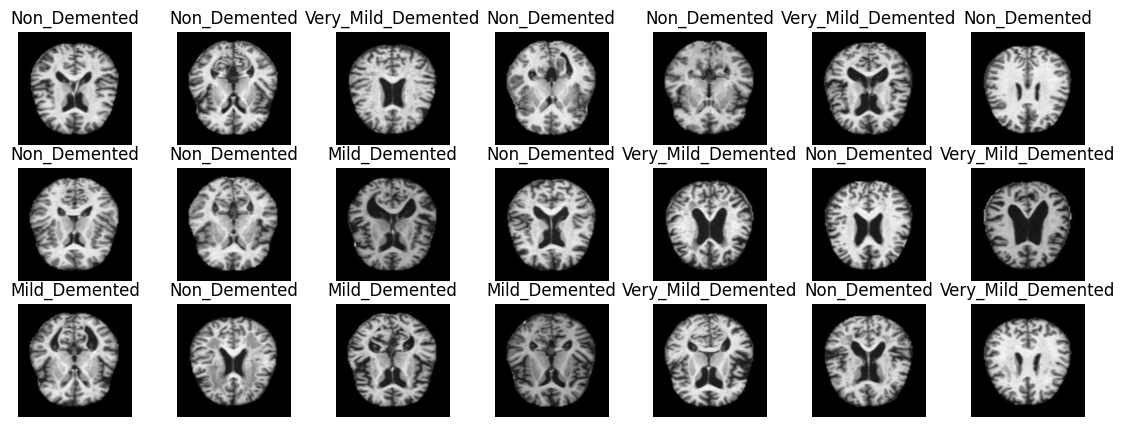

In [28]:
plot_images(data=val_data)

## Unpacking batches to create confusion matrix

In [29]:
# Initialize empty lists to store images and labels
val_images = []
val_labels = []

# Iterate through the test dataset and append each batch to a list
for batch in val_data.as_numpy_iterator():
    val_images.append(batch[0])
    val_labels.append(batch[1])

# Concatenate the batches into a single array for both images and labels
val_images = np.concatenate(val_images, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

In [30]:
y_pred = np.array(model.predict(val_images))
y_true = np.array(val_labels)

40/40 [==============================] - 16s 398ms/step


### Getting most probable label for an image from test dataset

In [31]:
# Use the trained model to predict the labels for the test images
y_pred = model.predict(val_images)

# Convert the predicted probabilities to class labels
y_pred = tf.argmax(y_pred, axis=1).numpy()

40/40 [==============================] - 16s 399ms/step


### Creating a list with missclassified labels

In [32]:
# Get the indices of the incorrectly classified images
incorrect_indices = np.nonzero(y_pred != y_true)[0]

# Get the incorrectly classified images and labels
false_class = list(zip(val_images[incorrect_indices], y_pred[incorrect_indices], y_true[incorrect_indices]))

# Get the correctly classified images and labels
correct_indices = np.nonzero(y_pred == y_true)[0]
true_class = list(zip(val_images[correct_indices], y_pred[correct_indices], y_true[correct_indices]))

## Confusion Matrix

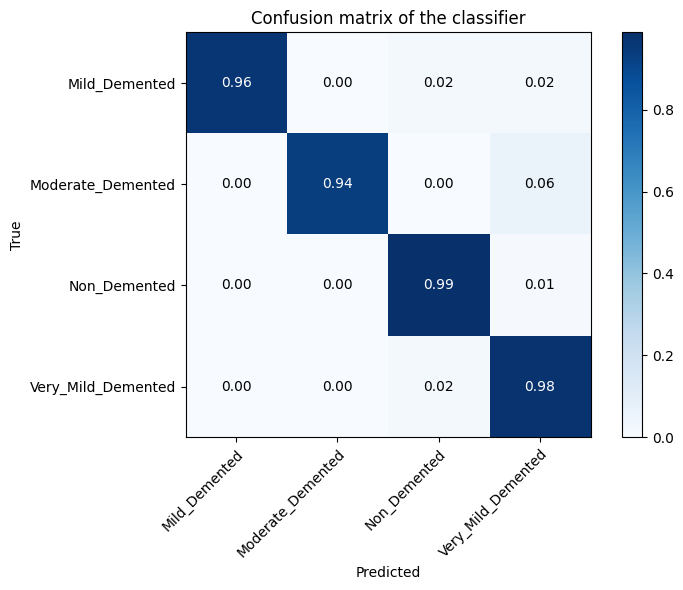

In [33]:
# Compute the confusion matrix for the predicted labels and true labels
cm = confusion_matrix(y_true, y_pred, normalize='true')

# Create a heatmap visualization of the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set tick labels
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Rotate the tick labels and set axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

# Loop over data to create annotations
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, format(cm[i, j], '.2f'),
                       ha="center", va="center", color="white" if cm[i, j] > 0.5 else "black")

# Set title and show the plot
ax.set_title("Confusion matrix of the classifier")
fig.tight_layout()
plt.show()

## Plotting errors

In [34]:
def plot_predictions(labels, cols=5):
    number_of_misscl = round((1 - accuracy) * len(val_data) * batch_size)
    random.shuffle(labels)
    rows = int(number_of_misscl/cols)-1
    fig = plt.figure(figsize=(cols*10, 45))
    for i in range(1, cols*rows +1):
        fig.add_subplot(rows, cols, i)
        plt.title(f'Pred: {class_names[labels[i][1]]}\nTrue: {class_names[labels[i][2]]}',fontsize=40)
        plt.axis("off")
        plt.imshow(labels[i][0].astype("uint16"))
    plt.tight_layout()

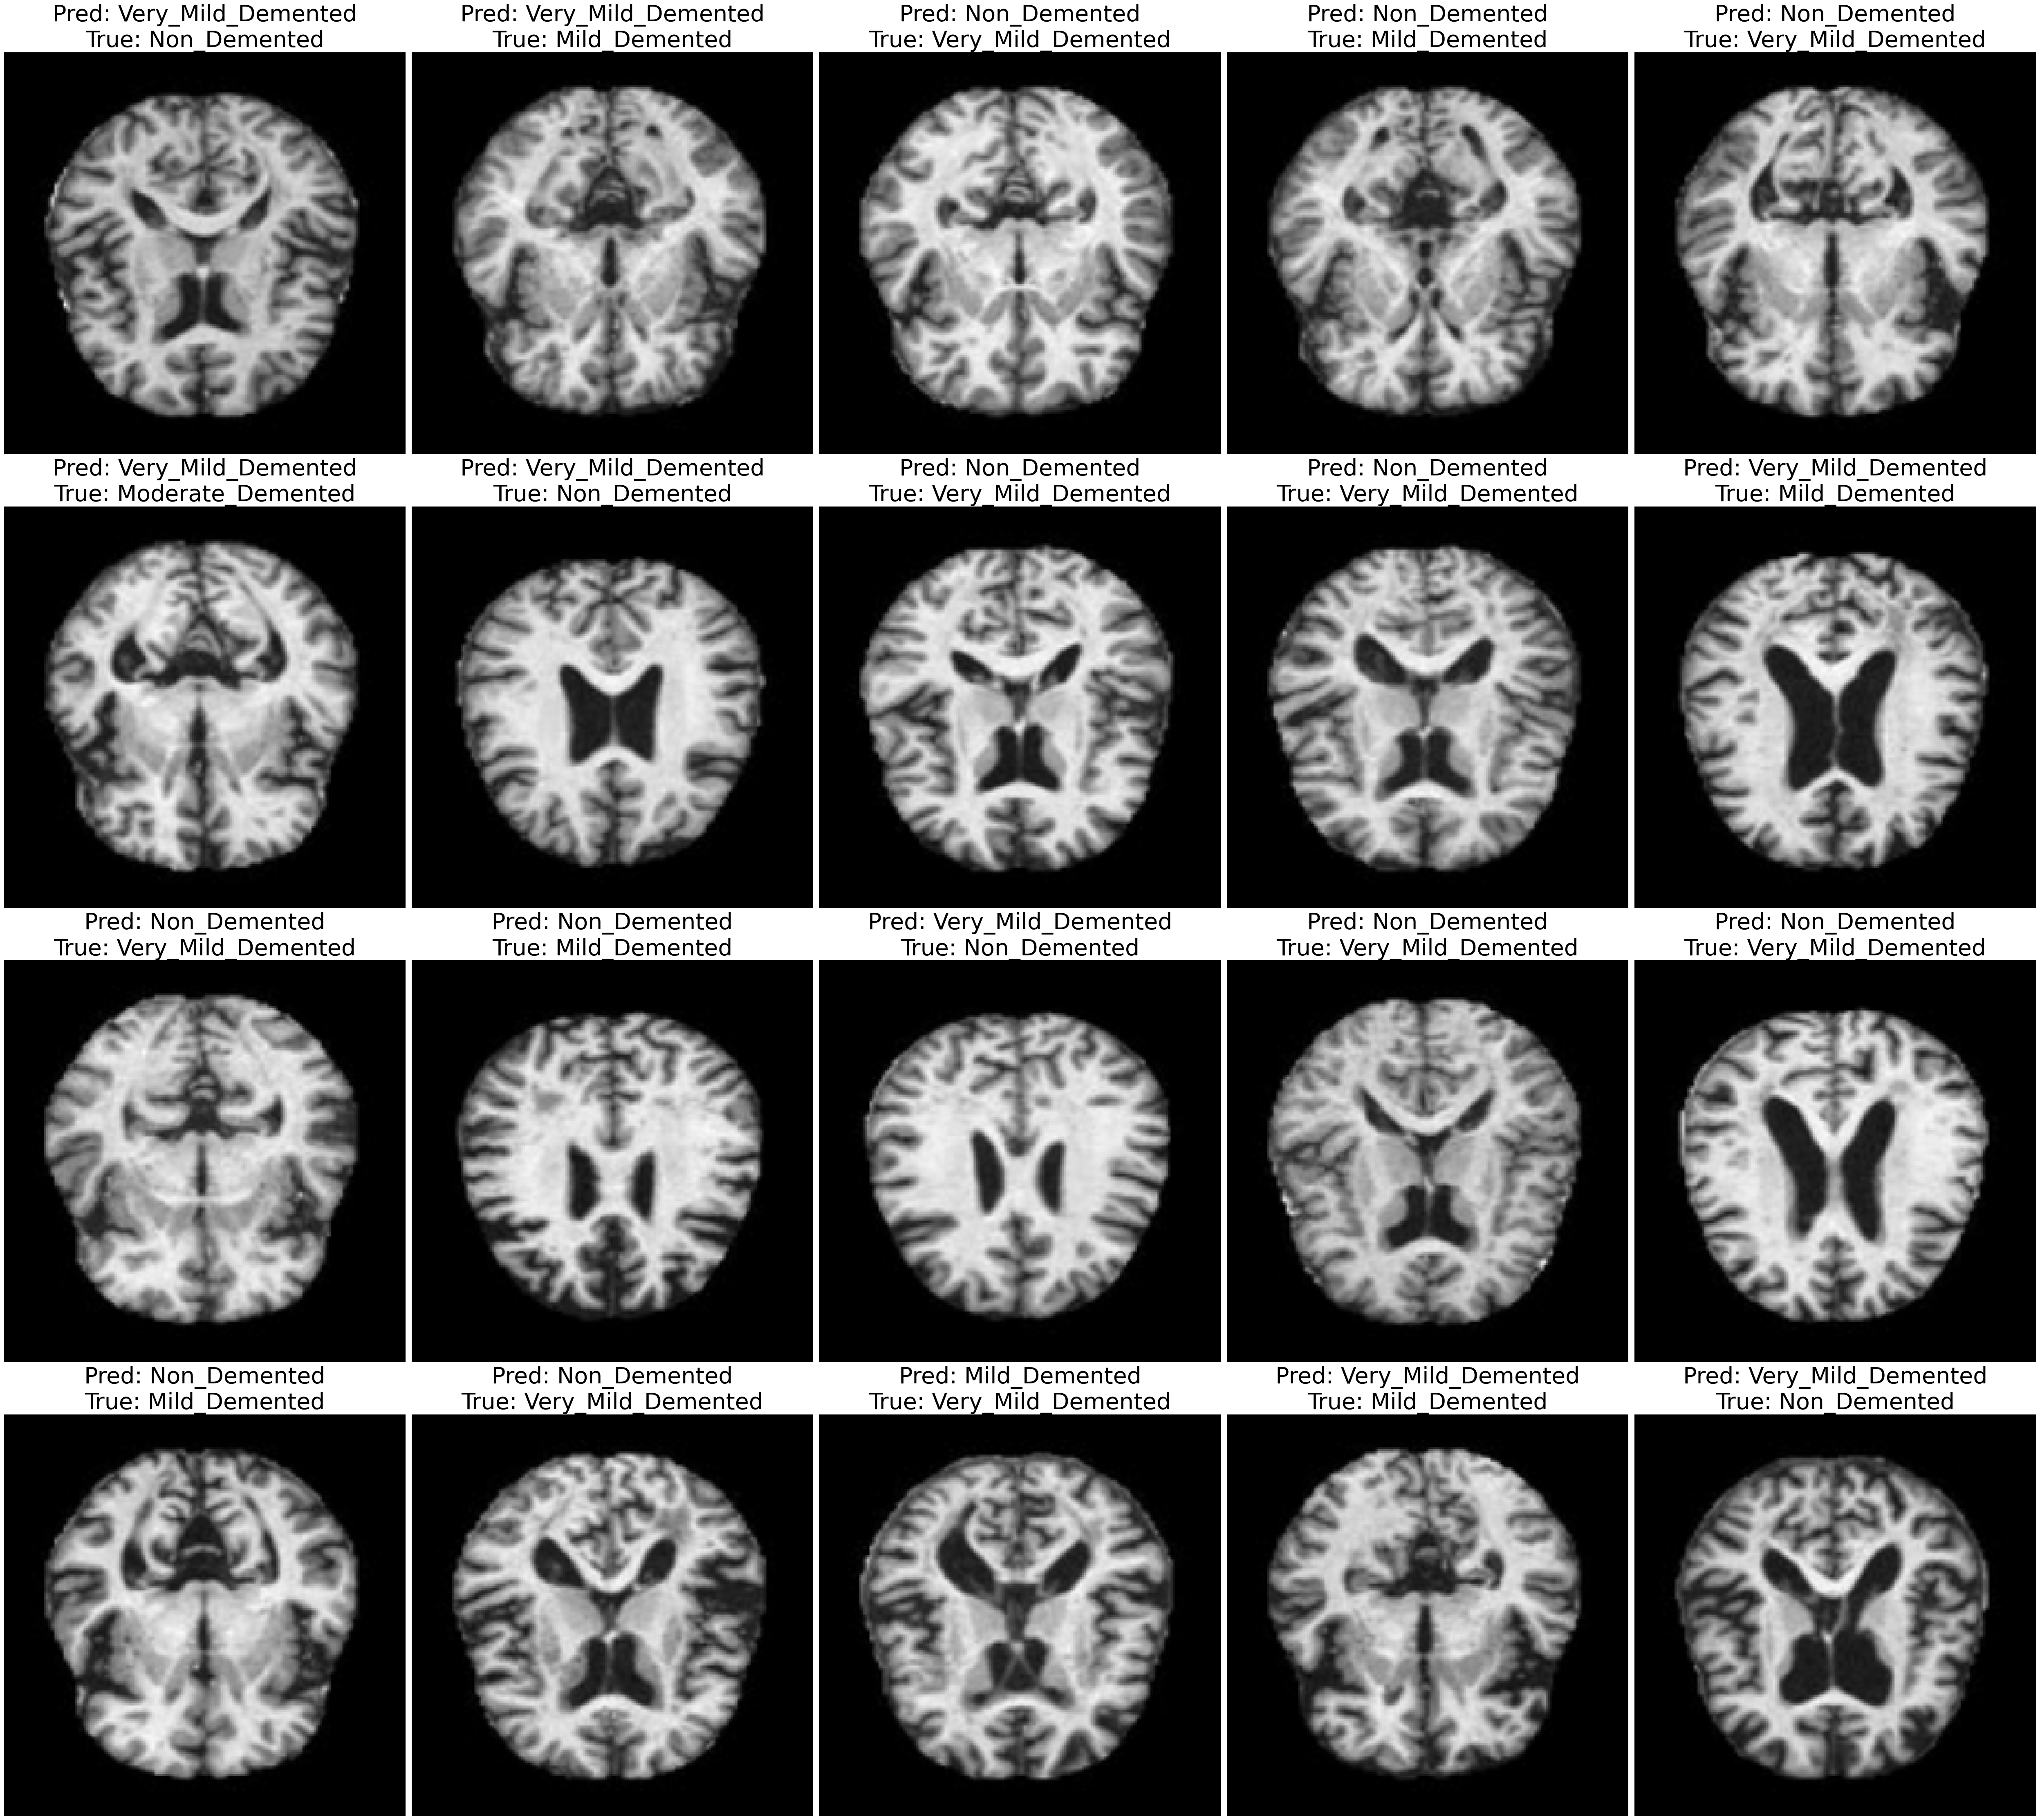

In [35]:
plot_predictions(false_class, cols=5)